# News Clustering using KMeans Algorithm

In [1]:
import numpy as np
import pandas as pd
from time import time
import articles_data_py3 as articles_data
from pymongo import MongoClient
import datetime

## Load data from MongoDB 

In [2]:
client = MongoClient('mongodb://localhost:27017/somanews')
client.somanews.authenticate('ssomanews', 'ssomanews1029')
db = client.get_database('somanews')

crawled_collection = db.get_collection('crawledArticles')
clusters_collection = db.get_collection('aclusters')
articles_collection = db.get_collection('aarticles')

## Select Categories
- 포함 : 경제, 문화, 건강, 과학, 사회, 정치, 스포츠
- 제외 : 종합, 정보없음, 인물, 사설

In [3]:
catelist_path = '../datastore/category.p'
headline_path = '../datastore/headline.p'
target_time = datetime.datetime.now()
date = int(target_time.strftime('%m%d'))

In [4]:
train = articles_data.find_recent_articles(crawled_collection, catelist_path, target_time)

## Preprocessing
1. Datetime (16-09-11 ~ 16-09-17)
2. Remove stopwords (regex, hanja)
3. POS Tagging with KoNLPy, Mecab
4. Using bigram

In [5]:
from konlpy.tag import Mecab
import cnouns
import hanja
import re

In [6]:
mecab = Mecab()

In [7]:
def tokenize(data):
    return [' '.join(e for e in mecab.nouns(data))]

In [8]:
train['title_flat'] = train['title'].apply(lambda text: articles_data.remove_headlines(text, headline_path))
train['title_flat'] = train['title_flat'].apply(lambda text: cnouns.text_cleaning_without_special_ch(text))
title = [tokenize(each[1]['title_flat']) for each in train.iterrows()]

## Training
1. Feature extraction - TfidVectorizer
2. Decomposition - PCA
3. Cluster - KMeans

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [10]:
vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1,2))
title_flat = [item for sublist in title for item in sublist]
x_list = vectorizer.fit_transform(title_flat)

In [11]:
x_list_100d = PCA(n_components=100).fit_transform(x_list.toarray())
x_list_100d.shape

(2582, 100)

### Scoring

In [12]:
from sklearn.metrics import silhouette_samples, silhouette_score
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Best Silhoutte Score

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
best_score = 0.0
best_k = 0

In [15]:
k_list = []
score_list = []
for k in range(20, 35):
    km = KMeans(n_clusters=k, n_jobs=-1).fit(x_list_100d)
    score = silhouette_score(x_list_100d, km.labels_)
    if best_score < score:
        best_score = score
        best_k = k
    k_list.append(k)
    score_list.append(score)
print("In Clusters =", best_k, ", Best score is : %0.3f" % best_score)

In Clusters = 28 , Best score is : 0.169


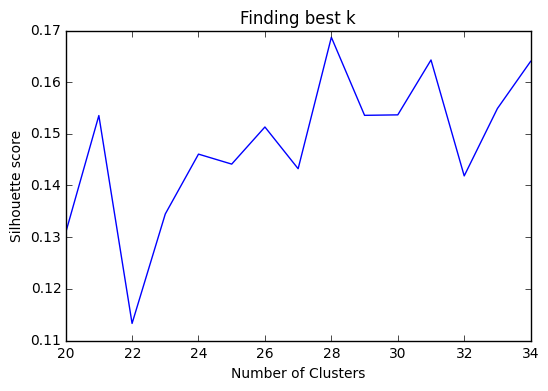

In [16]:
x = k_list
y = score_list
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')
plt.title('Finding best k')
plt.plot(x, y)
plt.show()

### K-Means Algorithm

In [17]:
km = KMeans(n_clusters=best_k, n_jobs=-1).fit(x_list_100d)
labels = km.labels_
centroids = km.cluster_centers_
print(km.inertia_)

243.184803579


In [18]:
x_list_vector = x_list_100d.tolist()
train = train.drop(['title_flat'], axis=1)
train['vector'] = x_list_vector
train['cluster'] = labels

## Choose Best Cluster
- Minimum inertia

In [19]:
sample_silhouette_values = silhouette_samples(x_list_100d, labels)
sample_silhouette_score = []
list_silhouette_score = []
best_cluster = []

for i in range(best_k):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels == i]    
    list_silhouette_score.append(abs(ith_cluster_silhouette_values.mean()))

list_silhouette_score.sort(reverse=True)
sample_silhouette_score = list_silhouette_score[:15]

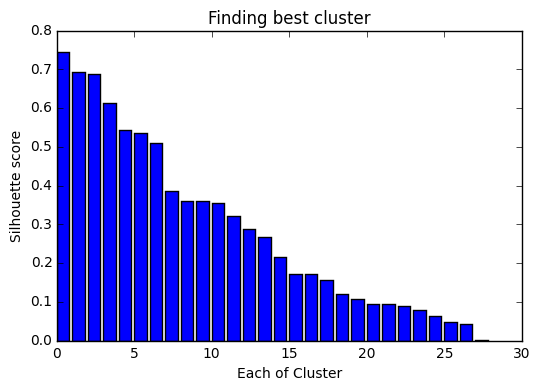

In [20]:
x = [x for x in range(best_k)]
y = list_silhouette_score
plt.xlabel('Each of Cluster')
plt.ylabel('Silhouette score')
plt.title('Finding best cluster')
plt.bar(x, y)
plt.show()

In [21]:
sample_silhouette_score

[0.74470091560985308,
 0.69234802303069054,
 0.68740392098691916,
 0.61236010887948755,
 0.54431239933280062,
 0.53633567051076858,
 0.50947320455819156,
 0.38680091422708374,
 0.35965972630045873,
 0.3589488281353469,
 0.35357810569892828,
 0.32176347910415964,
 0.28801865996262255,
 0.26670684389925065,
 0.21610043140417681]

In [22]:
cohesions = []

In [23]:
for i in range(best_k):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels == i]
        
    if abs(ith_cluster_silhouette_values.mean()) in sample_silhouette_score:
        best_cluster.append(i)
        cohesions.append(abs(ith_cluster_silhouette_values.mean()))

In [24]:
clusters = train[train['cluster'].isin(best_cluster)]
train['cluster'] = train['cluster'] + date * 1000
cohesions

[0.26670684389925065,
 0.28801865996262255,
 0.50947320455819156,
 0.38680091422708374,
 0.69234802303069054,
 0.54431239933280062,
 0.32176347910415964,
 0.3589488281353469,
 0.68740392098691916,
 0.61236010887948755,
 0.74470091560985308,
 0.53633567051076858,
 0.35965972630045873,
 0.35357810569892828,
 0.21610043140417681]

## Save to MongoDB

In [25]:
articles_data.save_to_articles(train, articles_collection)
articles_data.save_to_clusters(clusters, date, clusters_collection, cohesions)
client.close()

Number of clusters is 15
